In [27]:
from dotenv import load_dotenv

import os

load_dotenv()

google_key = os.getenv("google_key")

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [28]:
from tools import *

In [29]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Santos x Mirassol', 'Al-Hilal x Al-Fateh', 'Vasco da Gama x Bangu']

In [30]:
contents_news = get_serper_with_scrapping(trends_list, k=3)

100%|██████████| 3/3 [00:21<00:00,  7.28s/it]


In [31]:
contents_news

{'Santos x Mirassol': [{'title': 'Santos x Mirassol: onde assistir e detalhes do jogo da Série B',
   'link': 'https://www.flashscore.com.br/noticias/futebol-serie-b-santos-x-mirassol-onde-assistir-e-detalhes-do-jogo-da-serie-b/prtWrrAd/',
   'snippet': 'O duelo é um confronto direto pelas primeiras posições na tabela. O Santos tem três pontos a mais que o Mirassol e vem de derrota para o Goiás...',
   'date': 'Oct 12, 2024',
   'position': 1,
   'content': '\n\n\n\nSantos x Mirassol: onde assistir e detalhes do jogo da Série B | Flashscore.com.br \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPublicidadePublicidadePublicidade\n\n\n\n\n\n\n\n\n\n\n\n\n                        Resultados\n                    \n\n\n\n\n\n\n                        Notícias\n                    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [32]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    subjects: List[str] # New attribute
    newsletter: str
    destinatarios: List[str] #para enviar emails

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [33]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
        llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [34]:
from IPython.display import Markdown
import smtplib # Para enviar email
from email.message import EmailMessage #pra deixar no formato que envia email

from pydantic import BaseModel, Field
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    # news = get_serper_with_scrapping(queries=trends, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}


def send_email(state: GraphState):
    print()
    print("--- ENVIANDO EMAIL---")
    
    # Configurações do e-mail
    remetente = "gabriellycarneirosusko@gmail.com"
    senha = google_key
    destinatarios = state["destinatarios"]
    
    # Criar a mensagem
    mensagem = EmailMessage()
    mensagem["Subject"] = "Assunto do E-mail"  # Assunto
    mensagem["From"] = remetente
    mensagem["To"] = ", ".join(destinatarios)
    mensagem.set_content(state["newsletter"])

    # Configuração do servidor SMTP
    servidor_smtp = "smtp.gmail.com"
    porta = 587

    try:
        # Conectar ao servidor SMTP
        with smtplib.SMTP(servidor_smtp, porta) as servidor:
            servidor.starttls()  # Iniciar comunicação segura
            servidor.login(remetente, senha)  # Fazer login
            servidor.send_message(mensagem)  # Enviar a mensagem
            print("E-mail enviado com sucesso!")
    except Exception as e:
        print(f"Erro ao enviar o e-mail: {e}")
        
def classifica_futebol(state: GraphState) -> dict:

    model_name_openai = "gpt-4o-2024-08-06" # Garante 100% do output em JSON

    llm_openai = ChatOpenAI(
        model=model_name_openai, # 100% json output
        temperature=0,
    )

    system_prompt = """
    Você é um classificador que vai verificar notícias que falam especificamente de futebol. 
    Você precisa classificar a notícia como YES ou NO, dependendo se o texto fala de futebol ou não.
    Você deve classificar como NO qualquer notícia que fale do SANTOS
    """

    prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt), 
                ("human", "query do usuário: \n\n {query}")
            ]
    )

    class GetSchema(BaseModel):
        """Schema de futebol"""
        
        resultado: str = Field(description="YES caso o texto fale de FUTEBOL e NO caso contrário", examples=['YES', 
                                                                                                        'NO'])

    news = state["news"]
    noticias_futebol = {}

    llm_openai_with_tools_extraction = llm_openai.bind_tools([GetSchema]) #, strict=True)
    chain_openai_structured_extraction = prompt | llm_openai_with_tools_extraction
    for assunto, noticias in news.items():
        for materia in noticias:
            content = (materia['content'])
            response = chain_openai_structured_extraction.invoke({"query": content})
            try:
                result = response.tool_calls[0]['args']['resultado']
                if result == "YES":
                    noticias_futebol[assunto] = noticias
            except:
                pass
                
    return {"news": noticias_futebol}
        

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [35]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("classifica_futebol", classifica_futebol)
    workflow.add_node("create_newsletter", create_newsletter)
    workflow.add_node("send_email", send_email)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "classifica_futebol")
    workflow.add_edge("classifica_futebol", "create_newsletter")
    workflow.add_edge("create_newsletter", "send_email")
    workflow.add_edge("send_email", END)

    # Compile
    app = workflow.compile()
    return app

In [36]:
app = compile_workflow()

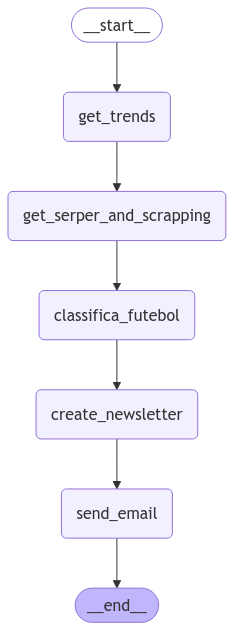

In [37]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [38]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import os
import certifi
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()


In [39]:
destinatarios = ['gabriellycarneirosusko@gmail.com']

response = app.invoke({"country": "brazil",
                       "head": 3,
                       "subjects": ["Educação"],
                       "k": 2,
                       "destinatarios": destinatarios})

---GET TRENDS---

--> Assuntos adicionais:  ['Educação']
Trend List:  ['Santos x Mirassol', 'Al-Hilal x Al-Fateh', 'Vasco da Gama x Bangu']

---GET SERPER AND SCRAPPING---



100%|██████████| 4/4 [00:28<00:00,  7.00s/it]


---Santos x Mirassol---
Santos x Mirassol: onde assistir e detalhes do jogo da Série B
Santos x Mirassol: vidente crava resultado
Santos terá três desfalques diante da Chapecoense após batalha contra o Mirassol

---Al-Hilal x Al-Fateh---
Al Hilal - Al Fateh prediction & tips 16.01.2025
Officially... Al-Fateh includes Suhaib Al-Zaid from Al-Hilal
Goal! Revamped Roshn Saudi League is on now

---Vasco da Gama x Bangu---
Vasco Hosts Bangu at São Januário in Search of First Carioca Victory
Veja os resultados da rodada e a classificação do Carioca Sub-20
Bangu x Vasco: onde assistir, palpites e escalações – Campeonato Carioca – 28/01/2024

---Educação---
Prefeitura de SP oferece curso em Educação em Direitos Humanos para Agentes de Busca Ativa Escolar
Indígenas ocupam pelo 3º dia sede da Secretaria de Estado de Educação e pedem permanência de aulas presenciais no PA; entenda
Educação de Jovens e Adultos (EJA) está com matrículas abertas para os Ensinos Fundamental e Médio

---CREATE NEWSLETT

**Newsletter de Esportes - Destaques do Dia**

**1. Al Hilal vs Al Fateh: A Grande Expectativa na Saudi Pro League**
O Al Hilal, líder da Saudi Pro League, enfrenta o Al Fateh, que luta contra a zona de rebaixamento, em um jogo que promete ser emocionante. Com um desempenho impressionante, o Al Hilal possui 12 vitórias em 14 jogos, enquanto o Al Fateh amarga a última posição com apenas uma vitória. As odds favorecem claramente o Al Hilal, com uma vitória cotada a 1.05. O jogo acontece amanhã, 16 de janeiro, às 16h05, no Kingdom Arena, em Riyadh. [Leia mais aqui](https://www.transfermarkt.com/betting/tips/al-hilal-vs-al-fateh-prediction-16-01-2025/).

**2. Al-Dawsari Brilha em Vitória do Al Hilal**
Salem Al-Dawsari, eleito o Melhor Jogador da Ásia, foi fundamental na vitória do Al Hilal sobre o Al Fateh por 2-0. O jogador abriu o placar com um pênalti e fechou o jogo com um gol espetacular, consolidando a liderança do Al Hilal na liga. O time agora está sete pontos à frente do segundo colocado. [Confira a cobertura completa](https://www.arabnews.com/node/2402801/sport).

**3. Vasco da Gama em Busca da Primeira Vitória no Carioca**
O Vasco da Gama enfrenta o Bangu no Estádio São Januário, buscando sua primeira vitória no Campeonato Carioca. O time, que ainda não pontuou, está sob pressão após a demissão do técnico Alexandre Gomes. A partida está marcada para o dia 28 de janeiro, às 16h, e será transmitida ao vivo pela Band e Bandsports. [Saiba mais sobre o jogo](https://www.footboom1.com/en/news/football/2301227-vasco-hosts-bangu-at-sao-januario-in-search-of-first-carioca-victory).

**4. Bangu e Vasco: Um Confronto de Rivalidade**
O histórico entre Bangu e Vasco é favorável ao Cruz-Maltino, que venceu 130 dos 210 confrontos. O Bangu, por sua vez, busca reverter a situação após três derrotas consecutivas. O jogo promete ser um teste crucial para ambos os times. [Leia mais sobre as expectativas para o jogo](https://esportenewsmundo.com.br/bangu-x-vasco-retrospecto-provaveis-escalacoes-arbitragem-onde-assistir-e-palpites/).

**5. Vasco Tropeça e Torcedores Culparam o Flamengo**
Após um empate em 2-2 com o Bangu, torcedores do Vasco expressaram sua frustração nas redes sociais, culpando a arbitragem e insinuando que o árbitro tinha ligações com o Flamengo. O Vasco agora se prepara para um confronto crucial contra seu rival. [Entenda a polêmica](https://colunadofla.com/2024/01/que-loucura-vasco-tropeca-contra-o-bangu-e-torcedores-culpam-o-flamengo/).

Fique ligado para mais atualizações sobre os jogos e as performances dos seus times favoritos!


--- ENVIANDO EMAIL---
E-mail enviado com sucesso!


## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.

custa 0.008 cents

In [40]:
from pydantic import BaseModel, Field
from typing import List
from langchain_groq import ChatGroq

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def classifica_futebol(query):

    model_name_openai = "gpt-4o-2024-08-06" # Garante 100% do output em JSON

    llm_openai = ChatOpenAI(
        model=model_name_openai, # 100% json output
        temperature=0,
    )

    system_prompt = """
    Você é um assistente de IA muito prestativo que vai auxiliar um jornalista a classificar notícias que falam especificamente de futebol. Você precisa classificar a notícia como YES ou NO, dependendo se o texto fala de futebol ou não.
    """

    prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt), 
                ("human", "query do usuário: \n\n {query}")
            ]
    )

    class GetSchema(BaseModel):
        """Schema de futebol"""
        
        resultado: str = Field(description="YES caso o texto fale de FUTEBOL e NO caso contrário", examples=['YES', 
                                                                                                        'NO'])
        

    llm_openai_with_tools_extraction = llm_openai.bind_tools([GetSchema]) #, strict=True)
    chain_openai_structured_extraction = prompt | llm_openai_with_tools_extraction
    return chain_openai_structured_extraction.invoke({"query": query})